<img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png">

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Analysis of Model Predictions

A `MoonshotML` strategy encompasses both the model's training and predictions and what we choose to do with those predictions in our trading logic. That's a lot to worry about in the initial research stage. To separate concerns, we can retrieve the model predictions from our backtest results and analyze the predictions in a notebook, which might illuminate how we want to use the predictions.

## Retrieve predictions and prices


In `predictions_to_signals`, we save the predictions, closing prices, and volume DataFrames to the backtest results: 

```python
...
# Save the predictions and prices so we can analyze them
self.save_to_results("Prediction", predictions)
self.save_to_results("Close", closes)
self.save_to_results("Volume", volumes)
...
```

To get these fields back, we must re-run the walk-forward optimization with `details=True`:

In [2]:
from quantrocket.moonshot import ml_walkforward
ml_walkforward("kitchensink-ml",
                start_date="1998-12-31",
                end_date="2018-12-31",
                train="Y",
                min_train="3Y",
                segment="Y",
                details=True,
                model_filepath="pca_sgd_model.joblib",
                progress=True,
                filepath_or_buffer="kitchensink_ml_details*")

## Load predictions and prices

Using `details=True` on a large universe results in a large backtest results CSV. To make it easier to load, we use `csvgrep` to isolate particular fields before we loading anything into memory:

In [ ]:
!csvgrep -c Field -m Prediction kitchensink_ml_details_results.csv > kitchensink_ml_details_results_Prediction.csv
!csvgrep -c Field -m Close kitchensink_ml_details_results.csv > kitchensink_ml_details_results_Close.csv
!csvgrep -c Field -m Volume kitchensink_ml_details_results.csv > kitchensink_ml_details_results_Volume.csv

Then we load only these fields:

In [1]:
import pandas as pd
predictions = pd.read_csv("kitchensink_ml_details_results_Prediction.csv", parse_dates=["Date"], index_col=["Field","Date"]).loc["Prediction"]
closes = pd.read_csv("kitchensink_ml_details_results_Close.csv", parse_dates=["Date"], index_col=["Field","Date"]).loc["Close"]
volumes = pd.read_csv("kitchensink_ml_details_results_Volume.csv", parse_dates=["Date"], index_col=["Field","Date"]).loc["Volume"]

EmptyDataError: No columns to parse from file

Let's split our predictions into 5 bins and compare one-week forward returns for each bin:

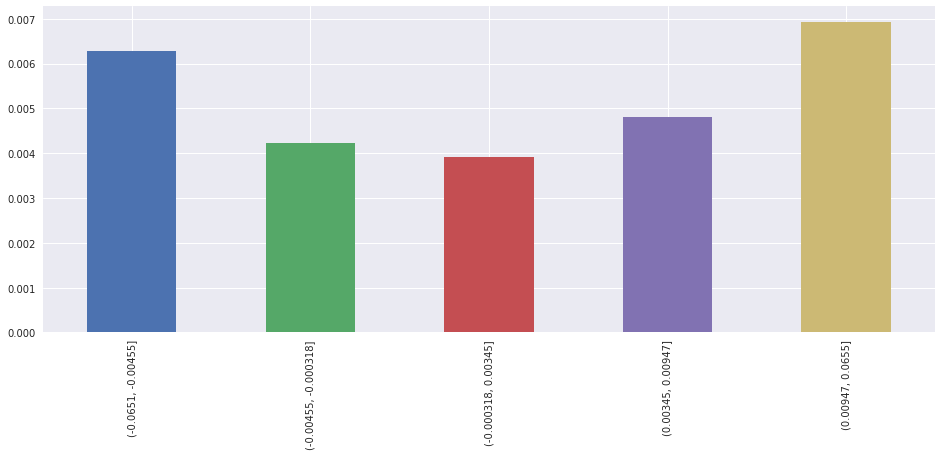

In [3]:
# Calculate one week returns
one_week_returns = (closes - closes.shift(5)) / closes.shift(5)

# Shift one week returns back to time of prediction, and stack returns and predictions 
one_week_forward_returns_stacked = one_week_returns.shift(-5).stack(dropna=False)
predictions_stacked = predictions.stack(dropna=False)

# Bin predictions into 5 equal-size bins
prediction_bins = pd.qcut(predictions_stacked, 5)

# Plot returns by bin
one_week_forward_returns_stacked.groupby(prediction_bins).mean().plot(kind="bar")

***

[Back to Introduction](Introduction.ipynb)